In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
from statsmodels.stats import multitest
from scipy import stats
import collections
import gzip
import time
import os

# Read in MOp gene/ontology and nuclear count data and correlate

In [2]:
mop_df = pd.read_csv('../outputs/gene_ontology/MOp_peripheral_ReadZs_gene_ontology.csv')


#Read in the Nuc-counts df and rename and filter
sn_df = pd.read_csv(
    '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10Xv3_snRNAseq/gene_ont_median_frac.csv'
)

sn_df = sn_df.rename(columns={
    'subclass':'ontology',
    'num_cells':'snRNAseq_cells',
})

sn_df['median_snRNAseq_TPM'] = sn_df['mean_cell_read_frac']*1e6
sn_df = sn_df.drop(columns='mean_cell_read_frac')
sn_df = sn_df[
    sn_df['snRNAseq_cells'].ge(20) &
    sn_df['median_snRNAseq_TPM'].le(2000)
]

#Read in the Nuc-counts df and rename and filter
sc_df = pd.read_csv(
    '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10Xv3_scRNAseq/gene_ont_mean_frac.csv'
)
sc_df = sc_df.rename(columns={
    'subclass':'ontology',
    'num_cells':'scRNAseq_cells',
})

sc_df['median_scRNAseq_TPM'] = sc_df['mean_cell_read_frac']*1e6
sc_df = sc_df.drop(columns='mean_cell_read_frac')
sc_df = sc_df[
    sc_df['scRNAseq_cells'].ge(20) &
    sc_df['median_scRNAseq_TPM'].le(2000)
]



display(mop_df.head())
display(sn_df.head())
display(sc_df.head())

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449


,ontology,gene,snRNAseq_cells,median_snRNAseq_TPM
1,Astro,0610009O20Rik,28,166.419453
2,Astro,0610010F05Rik,75,369.739774
4,Astro,0610030E20Rik,30,308.537301
10,Astro,0610043K17Rik,40,230.501676
19,Astro,1110004F10Rik,35,238.942171


,ontology,gene,scRNAseq_cells,median_scRNAseq_TPM
1,Astro,0610009B22Rik,119,88.332256
2,Astro,0610009O20Rik,92,63.017340
3,Astro,0610010F05Rik,227,163.987628
5,Astro,0610012G03Rik,217,146.626124
7,Astro,0610030E20Rik,116,63.988721


In [3]:
#Combine the snRNAseq and the scRNAseq tables
seq_df = sn_df.merge(sc_df)
seq_df['nuc_median_TPM_fraction'] = seq_df['median_snRNAseq_TPM'].div(
    seq_df['median_snRNAseq_TPM']+seq_df['median_scRNAseq_TPM']
)
seq_df

,ontology,gene,snRNAseq_cells,median_snRNAseq_TPM,scRNAseq_cells,median_scRNAseq_TPM,nuc_median_TPM_fraction
0,Astro,0610009O20Rik,28,166.419453,92,63.017340,0.725339
1,Astro,0610010F05Rik,75,369.739774,227,163.987628,0.692750
2,Astro,0610030E20Rik,30,308.537301,116,63.988721,0.828230
3,Astro,0610043K17Rik,40,230.501676,106,44.316763,0.838742
4,Astro,1110004F10Rik,35,238.942171,218,143.193460,0.625281
...,...,...,...,...,...,...,...
182168,Vip,Zzz3,274,225.870286,1738,115.684423,0.661300
182169,Vip,a,98,227.520532,489,63.591133,0.781558
182170,Vip,mt-Nd3,79,1324.282765,2453,1828.484365,0.420038
182171,Vip,mt-Nd4l,133,1071.736734,2455,1498.769694,0.416936


In [4]:
seq_df.to_csv('../inputs/scRNAseq_vs_snRNAseq_median_TPMs.csv',index=None)

In [5]:
#Ontologies match between MERFISH and 10X snRNAseq
set(mop_df['ontology']).intersection(seq_df['ontology'])

{'Astro',
 'Endo',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6b',
 'Lamp5',
 'OPC',
 'Oligo',
 'Pvalb',
 'Sncg',
 'Sst',
 'Vip'}

In [6]:
m = mop_df.merge(seq_df)
m.head().T

,0,1,2,3,4
sample_id,m1s1,m1s2,m1s3,m1s4,m1s5
gene,Adra1b,Adra1b,Adra1b,Adra1b,Adra1b
ontology,L2/3 IT,L2/3 IT,L2/3 IT,L2/3 IT,L2/3 IT
num_cells,83,288,196,448,478
med_gene_spots,6,6,6,7,7
med_spots,526,707.5,577,689,686
med_score,0.0681199,0.0596838,0.0993976,0.0758733,0.0717501
score_sum,6.78676,14.05,13.5733,23.5056,31.752
var_sum,9.52754,31.8077,22.9644,47.6694,49.4127
z,2.19873,2.49121,2.83242,3.40449,4.51702


In [7]:
m.shape

(8326, 17)

In [9]:
m['bh_p'].le(0.05).value_counts()

False    4355
True     3971
Name: bh_p, dtype: int64

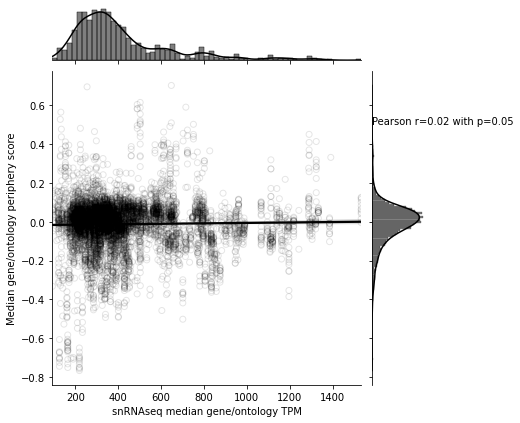

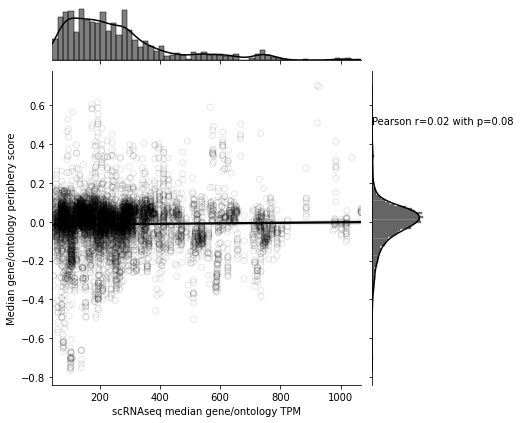

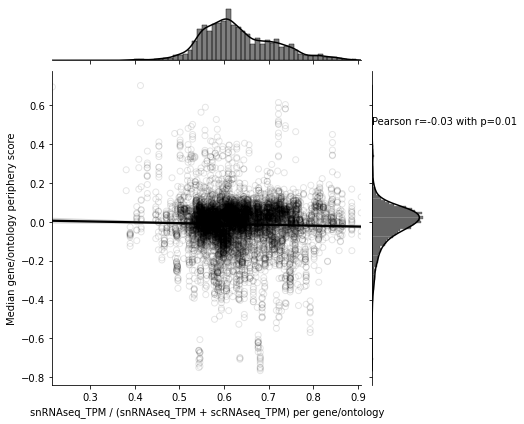

In [10]:
#snRNAseq
j = sns.jointplot(
    x = 'median_snRNAseq_TPM',
    y = 'med_score',
    kind = 'reg',
    color = 'black',
    scatter_kws = {
        'facecolor':'none',
        'alpha':0.1,
        'linewidth':1,
    },
    data = m,
)
r,p = stats.pearsonr(m['med_score'],m['median_snRNAseq_TPM'])
plt.text(0,0.5,'Pearson r={:.2f} with p={:.2f}'.format(r,p))
j.set_axis_labels(
    'snRNAseq median gene/ontology TPM',
    'Median gene/ontology periphery score',
)
plt.show(j)
j.savefig('nuclear_TPM_periph_corr.svg')
plt.close()

#scRNAseq
j = sns.jointplot(
    x = 'median_scRNAseq_TPM',
    y = 'med_score',
    kind = 'reg',
    color = 'black',
    scatter_kws = {
        'facecolor':'none',
        'alpha':0.1,
        'linewidth':1,
    },
    data = m,
)
r,p = stats.pearsonr(m['med_score'],m['median_scRNAseq_TPM'])
plt.text(0,0.5,'Pearson r={:.2f} with p={:.2f}'.format(r,p))
j.set_axis_labels(
    'scRNAseq median gene/ontology TPM',
    'Median gene/ontology periphery score',
)
plt.show(j)
j.savefig('cellular_TPM_periph_corr.svg')
plt.close()

#Fraction nuclear
j = sns.jointplot(
    x = 'nuc_median_TPM_fraction',
    y = 'med_score',
    kind = 'reg',
    color = 'black',
    scatter_kws = {
        'facecolor':'none',
        'alpha':0.1,
        'linewidth':1,
    },
    data = m,
)
r,p = stats.pearsonr(m['nuc_median_TPM_fraction'],m['med_score'])
plt.text(0,0.5,'Pearson r={:.2f} with p={:.2f}'.format(r,p))
j.set_axis_labels(
    'snRNAseq_TPM / (snRNAseq_TPM + scRNAseq_TPM) per gene/ontology',
    'Median gene/ontology periphery score',
)
plt.show(j)
j.savefig('nuclear_fraction_periph_corr.svg')
plt.close()

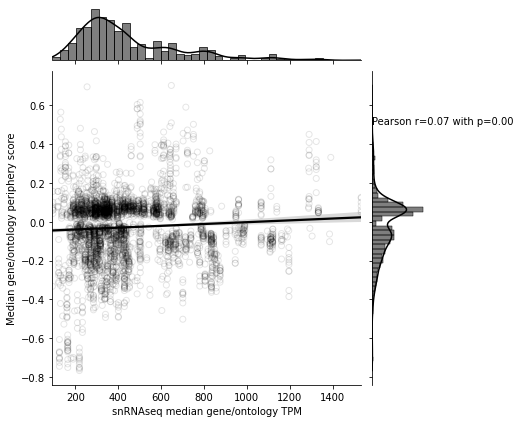

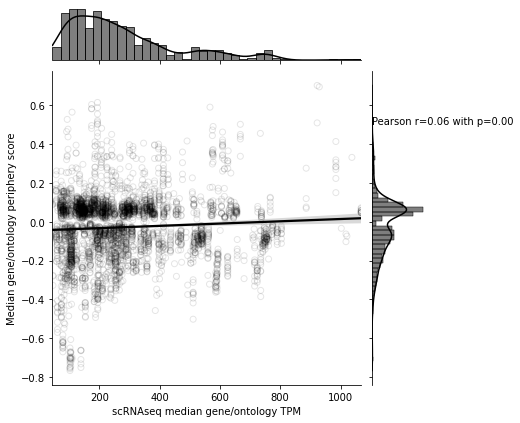

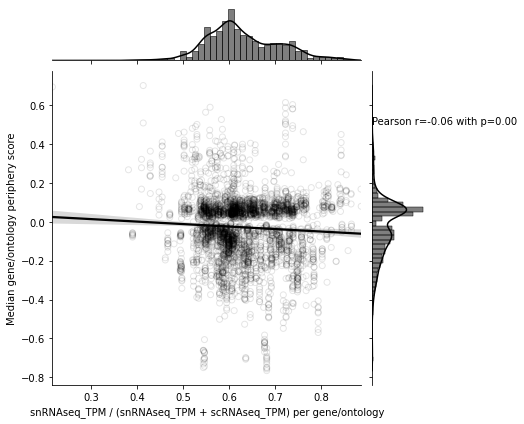

In [11]:
plot_m = m[m['bh_p'].le(0.05)]

#snRNAseq
j = sns.jointplot(
    x = 'median_snRNAseq_TPM',
    y = 'med_score',
    kind = 'reg',
    color = 'black',
    scatter_kws = {
        'facecolor':'none',
        'alpha':0.1,
        'linewidth':1,
    },
    data = plot_m,
)
r,p = stats.pearsonr(plot_m['med_score'],plot_m['median_snRNAseq_TPM'])
plt.text(0,0.5,'Pearson r={:.2f} with p={:.2f}'.format(r,p))
j.set_axis_labels(
    'snRNAseq median gene/ontology TPM',
    'Median gene/ontology periphery score',
)
plt.show(j)
j.savefig('nuclear_TPM_periph_corr_sigonly.svg')
plt.close()

#scRNAseq
j = sns.jointplot(
    x = 'median_scRNAseq_TPM',
    y = 'med_score',
    kind = 'reg',
    color = 'black',
    scatter_kws = {
        'facecolor':'none',
        'alpha':0.1,
        'linewidth':1,
    },
    data = plot_m,
)
r,p = stats.pearsonr(plot_m['med_score'],plot_m['median_scRNAseq_TPM'])
plt.text(0,0.5,'Pearson r={:.2f} with p={:.2f}'.format(r,p))
j.set_axis_labels(
    'scRNAseq median gene/ontology TPM',
    'Median gene/ontology periphery score',
)
plt.show(j)
j.savefig('cellular_TPM_periph_corr_sigonly.svg')
plt.close()

#Fraction nuclear
j = sns.jointplot(
    x = 'nuc_median_TPM_fraction',
    y = 'med_score',
    kind = 'reg',
    color = 'black',
    scatter_kws = {
        'facecolor':'none',
        'alpha':0.1,
        'linewidth':1,
    },
    data = plot_m,
)
r,p = stats.pearsonr(plot_m['nuc_median_TPM_fraction'],plot_m['med_score'])
plt.text(0,0.5,'Pearson r={:.2f} with p={:.2f}'.format(r,p))
j.set_axis_labels(
    'snRNAseq_TPM / (snRNAseq_TPM + scRNAseq_TPM) per gene/ontology',
    'Median gene/ontology periphery score',
)
plt.show(j)
j.savefig('nuclear_fraction_periph_corr_sigonly.svg')
plt.close()

In [11]:
#calculate pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate SRRS/nucSeq with too few ontologies per gene/sample
gene_sample_ontology_df = (
    m.groupby([
        'gene',
        'sample_id',
    ]).filter(
        lambda g: g['ontology'].nunique() >= 8)
)

for (gene,sample_id),g in gene_sample_ontology_df.groupby(['gene','sample_id']):
    r,p = stats.pearsonr(g['med_score'],g['nuc_median_TPM_fraction'])
    
    corr_data['gene'].append(gene)
    corr_data['sample_id'].append(sample_id)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
214,Satb2,m2s2,8,811.5,0.986202,0.000006,0.002067,True
315,Wipf3,m2s4,11,220.0,-0.902211,0.000145,0.020679,True
317,Wipf3,m2s6,12,190.0,-0.870141,0.000233,0.020679,True
310,Wipf3,m1s5,12,310.5,-0.867100,0.000260,0.020679,True
213,Satb2,m1s6,9,498.0,0.921980,0.000404,0.025722,True
...,...,...,...,...,...,...,...,...
148,Parm1,m1s3,9,256.0,-0.009450,0.980751,0.993245,False
204,Rgs6,m2s4,9,200.0,-0.006237,0.987295,0.995413,False
75,Col25a1,m2s2,8,49.5,-0.004350,0.991844,0.995413,False
291,Trp53i11,m2s6,8,247.5,-0.004116,0.992283,0.995413,False


In [12]:
corr_df['significant'].value_counts()

False    309
True       9
Name: significant, dtype: int64

In [13]:
corr_df[corr_df['significant']].sort_values('gene')

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
214,Satb2,m2s2,8,811.5,0.986202,0.000006,0.002067,True
213,Satb2,m1s6,9,498.0,0.921980,0.000404,0.025722,True
242,Slc30a3,m1s2,8,484.0,-0.936934,0.000598,0.028139,True
315,Wipf3,m2s4,11,220.0,-0.902211,0.000145,0.020679,True
317,Wipf3,m2s6,12,190.0,-0.870141,0.000233,0.020679,True
310,Wipf3,m1s5,12,310.5,-0.867100,0.000260,0.020679,True
313,Wipf3,m2s2,12,188.0,-0.840421,0.000619,0.028139,True
307,Wipf3,m1s2,12,305.0,-0.824237,0.000976,0.038777,True
306,Wipf3,m1s1,10,266.0,-0.868586,0.001110,0.039223,True


In [14]:
corr_df[corr_df['significant']].groupby('gene')['pearson_r'].mean()

gene
Satb2      0.954091
Slc30a3   -0.936934
Wipf3     -0.862116
Name: pearson_r, dtype: float64

In [196]:
interesting_genes = corr_df.loc[
    corr_df['significant'],
    'gene'
].unique()

interesting_genes

array(['Satb2', 'Wipf3', 'Slc30a3'], dtype=object)

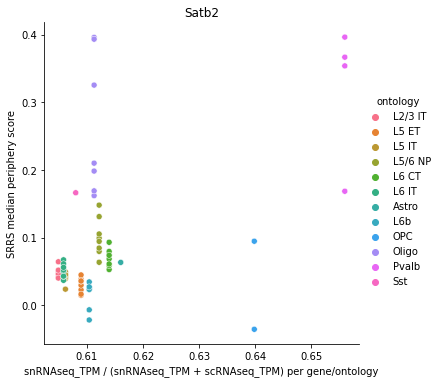

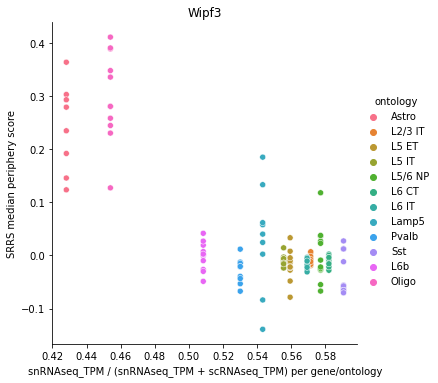

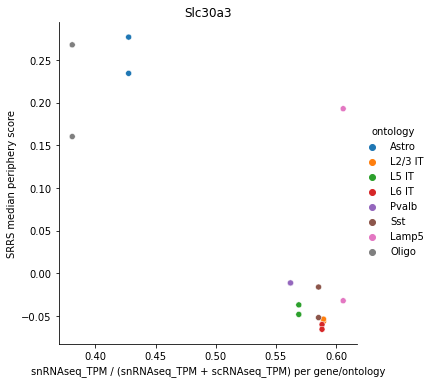

In [201]:
pdf = matplotlib.backends.backend_pdf.PdfPages("snRNAseq_periph_corr_interesting_genes.pdf")

for gene in interesting_genes:
    g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)].copy()
    
    #hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    fig = sns.relplot(
        x = 'nuc_median_TPM_fraction',
        y = 'med_score',
        hue = 'ontology',
        data = g,
    )
    plt.xlabel('snRNAseq_TPM / (snRNAseq_TPM + scRNAseq_TPM) per gene/ontology')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    plt.show(fig)
    #pdf.savefig(bbox_inches='tight')
    plt.close()
    

pdf.close()

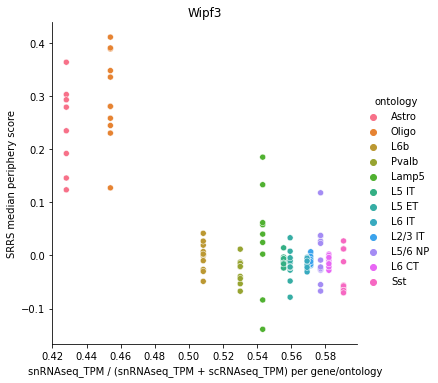

In [205]:
#Saving out Wipf3
gene = 'Wipf3'
g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)].copy()
hue_order = g.groupby('ontology')['nuc_median_TPM_fraction'].mean().sort_values().index

fig = sns.relplot(
    x = 'nuc_median_TPM_fraction',
    y = 'med_score',
    hue = 'ontology',
    hue_order = hue_order,
    data = g,
)
plt.xlabel('snRNAseq_TPM / (snRNAseq_TPM + scRNAseq_TPM) per gene/ontology')
plt.ylabel('SRRS median periphery score')
plt.title('{}'.format(gene))
plt.show(fig)
fig.savefig('wipf3_snRNAseq.svg')
plt.close()

In [207]:
g[['nuc_median_TPM_fraction','med_score']].corr()

,nuc_median_TPM_fraction,med_score
nuc_median_TPM_fraction,1.000000,-0.791644
med_score,-0.791644,1.000000


In [208]:
stats.pearsonr(g['nuc_median_TPM_fraction'],g['med_score'])

(-0.7916438831779118, 3.024304810199199e-30)

# Preprocessing scRNAseq counts per gene per cell

Have to merge multiple files to get gene/ontology read counts

In [81]:
counts_stem = '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10Xv3_snRNAseq'

#Read in the cell barcodes
barcode_path = os.path.join(counts_stem,'barcode.tsv')
barcode_df = pd.read_csv(barcode_path)
barcode_df.columns = ['barcode_id','cell_id']
barcode_df['barcode_id'] += 1 #1-indexing

#Read in the annotation metadata
clust_ann_path = os.path.join(counts_stem,'cluster.annotation.csv')
clust_ann_df = pd.read_csv(clust_ann_path)

clust_mem_path = os.path.join(counts_stem,'cluster.membership.csv')
clust_mem_df = pd.read_csv(clust_mem_path)
clust_mem_df.columns = ['cell_id','cluster_id']

cell_df = barcode_df.merge(clust_mem_df).merge(clust_ann_df) #merge the cell data
barcode_to_subclass = dict(cell_df[['barcode_id','subclass_label']].values)

#Read in the genes
feature_path = os.path.join(counts_stem,'features.tsv.gz')
feature_df = pd.read_csv(
    feature_path,
    sep = '\t',
    header = None,
    names = ['ENSMUS','gene','kind'],
)
feature_df.index.name = 'feature_id'
feature_df = feature_df.reset_index()
feature_df['feature_id'] += 1 #1-indexing
feature_id_to_gene = dict(feature_df[['feature_id','gene']].values)

#Read in the counts
mtx_path = os.path.join(counts_stem,'matrix.mtx.gz')
mtx_df = pd.read_csv(
    mtx_path,
    sep = ' ',
    comment = '%',
)
mtx_df.columns = ['feature_id','barcode_id','read_count']


mtx_df['subclass'] = mtx_df['barcode_id'].map(barcode_to_subclass)
mtx_df = mtx_df.dropna()

mtx_df['gene'] = mtx_df['feature_id'].map(feature_id_to_gene)
mtx_df = mtx_df.dropna()

mtx_df.head()

,feature_id,barcode_id,read_count,subclass,gene
5759,42,4,2,L6b,A830018L16Rik
5760,49,4,1,L6b,Ncoa2
5761,107,4,1,L6b,Kcnq5
5762,109,4,4,L6b,Rims1
5763,124,4,4,L6b,Adgrb3


In [82]:
tot_reads = mtx_df.groupby('barcode_id')['read_count'].transform('sum')
mtx_df['cell_read_frac'] = mtx_df['read_count'].div(tot_reads)
mtx_df.head()

,feature_id,barcode_id,read_count,subclass,gene,cell_read_frac
5759,42,4,2,L6b,A830018L16Rik,0.002789
5760,49,4,1,L6b,Ncoa2,0.001395
5761,107,4,1,L6b,Kcnq5,0.001395
5762,109,4,4,L6b,Rims1,0.005579
5763,124,4,4,L6b,Adgrb3,0.005579


In [83]:
agg_df = mtx_df.groupby(['subclass','gene']).agg(
    num_cells = ('barcode_id','nunique'),
    mean_cell_read_frac = ('cell_read_frac','mean'),
).reset_index()

agg_df.head()

,subclass,gene,num_cells,mean_cell_read_frac
0,Astro,0610009B22Rik,4,0.000449
1,Astro,0610009O20Rik,28,0.000166
2,Astro,0610010F05Rik,75,0.000370
3,Astro,0610012G03Rik,17,0.000689
4,Astro,0610030E20Rik,30,0.000309


In [84]:
agg_df.shape

(382898, 4)

In [85]:
agg_df.to_csv(os.path.join(counts_stem,'gene_ont_median_frac.csv'),index=None)

# Preprocessing scRNAseq counts

In [129]:
counts_stem = '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10Xv3_scRNAseq'

#Read in the cell barcodes
barcode_path = os.path.join(counts_stem,'barcode.tsv')
barcode_df = pd.read_csv(barcode_path)
barcode_df.columns = ['barcode_id','cell_id']
barcode_df['barcode_id'] += 1

#Read in the annotation metadata
clust_ann_path = os.path.join(counts_stem,'cluster.annotation.csv')
clust_ann_df = pd.read_csv(clust_ann_path)

clust_mem_path = os.path.join(counts_stem,'cluster.membership.csv')
clust_mem_df = pd.read_csv(clust_mem_path)
clust_mem_df.columns = ['cell_id','cluster_id']

cell_df = barcode_df.merge(clust_mem_df).merge(clust_ann_df) #merge the cell data
barcode_to_subclass = dict(cell_df[['barcode_id','subclass_label']].values)

#Read in the genes
feature_path = os.path.join(counts_stem,'features.tsv.gz')
feature_df = pd.read_csv(
    feature_path,
    sep = '\t',
    header = None,
    names = ['ENSMUS','gene','kind'],
)
feature_df.index.name = 'feature_id'
feature_df = feature_df.reset_index()
feature_df['feature_id'] += 1
feature_id_to_gene = dict(feature_df[['feature_id','gene']].values)

#Read in the total number of reads per barcode
tot_count_path = os.path.join(counts_stem,'tot_reads_per_barcode.csv')
tot_count_df = pd.read_csv(tot_count_path)
bc_to_tot_count = dict(tot_count_df[['barcode_id','total_reads']].values)


### Process in chunks

In [137]:
pd.options.mode.chained_assignment = None  # default='warn'

mtx_path = os.path.join(counts_stem,'matrix.mtx.gz')

mtx_df_iter = pd.read_csv(
    mtx_path,
    sep = ' ',
    skiprows = 3,
    header = None,
    names = ['feature_id','barcode_id','read_count'],
    chunksize = 10000000,
)

gene_ont_PPM_sums = collections.Counter()
gene_ont_num_cells = collections.Counter()

for i,mtx_df in enumerate(mtx_df_iter):
    start = time.time()
    mtx_df['subclass'] = mtx_df['barcode_id'].map(barcode_to_subclass)
    mtx_df = mtx_df.dropna()

    mtx_df['gene'] = mtx_df['feature_id'].map(feature_id_to_gene)
    mtx_df = mtx_df.dropna()
    
    mtx_df['PPM'] = 1e6*mtx_df['read_count'].div(mtx_df['barcode_id'].map(bc_to_tot_count))
    
    mtx_df['key'] = mtx_df[['gene', 'subclass']].apply(tuple, axis=1)
    agg_mtx_df = mtx_df.groupby('key').agg(
        PPM_sum = ('PPM','sum'),
        num_cells = ('barcode_id','nunique')
    ).reset_index()
    
    gene_ont_PPM_sums += collections.Counter(dict(agg_mtx_df[['key','PPM_sum']].values))
    gene_ont_num_cells += collections.Counter(dict(agg_mtx_df[['key','num_cells']].values))
    
    print('Processed',mtx_df['barcode_id'].nunique(),'cells in',time.time()-start,'seconds')
    
gene_ont_PPM_sums

Processed 1281 cells in 87.9503664970398 seconds
Processed 1242 cells in 85.9986400604248 seconds
Processed 1262 cells in 84.09039950370789 seconds
Processed 1298 cells in 88.08081579208374 seconds
Processed 1293 cells in 87.43401408195496 seconds
Processed 1026 cells in 53.79299759864807 seconds
Processed 928 cells in 35.946692943573 seconds
Processed 971 cells in 41.19620180130005 seconds
Processed 956 cells in 43.873071908950806 seconds
Processed 1000 cells in 45.053998708724976 seconds
Processed 959 cells in 43.06425976753235 seconds
Processed 991 cells in 46.285356760025024 seconds
Processed 1166 cells in 65.72959184646606 seconds
Processed 1326 cells in 87.18061399459839 seconds
Processed 1374 cells in 90.58214592933655 seconds
Processed 1356 cells in 87.6342556476593 seconds
Processed 1355 cells in 90.8245575428009 seconds
Processed 1482 cells in 99.6381983757019 seconds
Processed 1481 cells in 107.35976243019104 seconds
Processed 1482 cells in 106.12258529663086 seconds
Process

KeyboardInterrupt: 

In [ ]:
gene_ont_num_cells

In [ ]:
agg_df = pd.DataFrame({
    'gene_ont':gene_ont_num_cells.keys(),
    'num_cells':gene_ont_num_cells.values(),
})
PPM_sum = agg_df['gene_ont'].map(gene_ont_PPM_sums)
agg_df['mean_PPM'] = PPM_sum/agg_df['num_cells']

agg_df.head()

In [ ]:
agg_df.to_csv(os.path.join(counts_stem,'jup_gene_ont_mean_frac.csv'),index=None)

## Read counts table in chunks and do a first pass just to get per-cell sums

I'll store this as another lookup table and that will let me process chunks without having to worry about breaking a cell across a chunk

Hopefully this is faster than walking through the file line by line like I tried below which would have taken an hour to get through and was more error prone (coding errors by me)

In [126]:
pd.options.mode.chained_assignment = None  # default='warn'

mtx_path = os.path.join(counts_stem,'matrix.mtx.gz')

mtx_df_iter = pd.read_csv(
    mtx_path,
    sep = ' ',
    skiprows = 3,
    chunksize = 100000000,
    header = None,
    names = ['feature_id','barcode_id','read_count'],
)

cell_tot_counts = collections.Counter()

for i,mtx_df in enumerate(mtx_df_iter):
    start = time.time()
    mtx_df['subclass'] = mtx_df['barcode_id'].map(barcode_to_subclass)
    mtx_df = mtx_df.dropna()

    mtx_df['gene'] = mtx_df['feature_id'].map(feature_id_to_gene)
    mtx_df = mtx_df.dropna()
    
    sub_cell_tot_counts = mtx_df.groupby('barcode_id')['read_count'].sum().to_dict()
    cell_tot_counts += collections.Counter(sub_cell_tot_counts)
    
    print('Processed',len(sub_cell_tot_counts),'cells in',time.time()-start,'seconds')
    
cell_tot_counts

Processed 11251 cells in 26.760148763656616 seconds
Processed 12966 cells in 31.571251153945923 seconds
Processed 13026 cells in 29.286423444747925 seconds
Processed 13262 cells in 32.569419145584106 seconds
Processed 10629 cells in 21.0440194606781 seconds
Processed 11218 cells in 23.533368825912476 seconds
Processed 11431 cells in 28.275579929351807 seconds
Processed 10389 cells in 31.04557776451111 seconds


Counter({2: 1670,
         5: 90475,
         6: 122401,
         8: 74567,
         9: 11397,
         10: 1211,
         12: 73257,
         13: 50272,
         14: 3386,
         16: 44697,
         17: 902,
         19: 92591,
         20: 61196,
         22: 32027,
         23: 92206,
         24: 85627,
         25: 14961,
         26: 1996,
         28: 59077,
         29: 21593,
         33: 1478,
         36: 76819,
         37: 102086,
         38: 88123,
         39: 19898,
         40: 17048,
         41: 39854,
         42: 1474,
         44: 11540,
         45: 35670,
         46: 136535,
         47: 54392,
         48: 30348,
         49: 97228,
         50: 71452,
         51: 3626,
         53: 2858,
         56: 87443,
         57: 44543,
         58: 112430,
         59: 45552,
         60: 174760,
         62: 40706,
         63: 60068,
         64: 42998,
         65: 130462,
         66: 885,
         68: 845,
         70: 136217,
         71: 76927,
         73:

In [127]:
tot_count_df = pd.DataFrame({
    'barcode_id':cell_tot_counts.keys(),
    'total_reads':cell_tot_counts.values(),
})
tot_count_df

,barcode_id,total_reads
0,2,1670
1,5,90475
2,6,122401
3,8,74567
4,9,11397
...,...,...
94164,176579,33683
94165,176580,24090
94166,176581,63168
94167,176582,63360


In [128]:
tot_count_df.to_csv(
    os.path.join(counts_stem,'tot_reads_per_barcode'),
    index=None,
)

##  Read in the counts line by line (file too large to be read in at a single time)

The rows are sorted in cell order though which makes things easier

In [35]:
mtx_path = os.path.join(counts_stem,'matrix.mtx.gz')

gene_ont_PPM_sums = collections.defaultdict(int)
gene_ont_num_cells = collections.defaultdict(int)

processed_cell_count = 0
start = time.time()

with gzip.open(mtx_path,'rt') as f_in:
    f_in.readline() #comment line 1
    f_in.readline() #comment line 2
    f_in.readline() #header line
    
    curr_barcode_id = None
    gene_counts = {}
    cell_tot_reads = 0
    
    for line in f_in:
        feature_id,barcode_id,read_count = line.strip().split(' ')
        feature_id = int(feature_id)
        barcode_id = int(barcode_id)
        read_count = int(read_count)
        
        if barcode_id not in barcode_to_subclass:
            continue
        
        if curr_barcode_id and barcode_id != curr_barcode_id:
            processed_cell_count += 1
            if processed_cell_count%1000 == 0:
                duration = time.time()-start
                print('Processed',processed_cell_count,'cells in',duration,'seconds and storing',len(gene_ont_PPM_sums),'gene/onts')
                start = time.time()
            
            #update the gene_ont collections
            ont = barcode_to_subclass[curr_barcode_id]
            
            for gene,count in gene_counts.items():
                gene_ont_PPM_sums[(gene,ont)] += round(1e6*count/cell_tot_reads,2)
                gene_ont_num_cells[(gene,ont)] += 1
            
            #reset per-cell collections
            cell_data = []
            cell_tot_reads = 0
            
        #save counts for this cell
        curr_barcode_id = barcode_id
        cell_tot_reads += read_count
        gene = feature_id_to_gene[feature_id]
        gene_counts[gene] = read_count
    
gene_ont_PPM_sums

Processed 100 cells in 4.2421653270721436 seconds and storing 195899 gene/onts
Processed 200 cells in 4.379030466079712 seconds and storing 235125 gene/onts
Processed 300 cells in 4.824431896209717 seconds and storing 301455 gene/onts
Processed 400 cells in 4.7125084400177 seconds and storing 330160 gene/onts
Processed 500 cells in 4.724947929382324 seconds and storing 340705 gene/onts
Processed 600 cells in 4.852842092514038 seconds and storing 367810 gene/onts
Processed 700 cells in 4.922245025634766 seconds and storing 370801 gene/onts
Processed 800 cells in 5.041843414306641 seconds and storing 397320 gene/onts
Processed 900 cells in 4.990148067474365 seconds and storing 402731 gene/onts
Processed 1000 cells in 5.4836249351501465 seconds and storing 473903 gene/onts
Processed 1100 cells in 5.037438631057739 seconds and storing 476154 gene/onts
Processed 1200 cells in 5.172496795654297 seconds and storing 478663 gene/onts
Processed 1300 cells in 5.055394887924194 seconds and storing

KeyboardInterrupt: 

In [40]:
gene_ont_PPM_sums

defaultdict(int,
            {('AC149090.1', 'L5 IT'): 3507680.8100000024,
             ('Tmlhe', 'L5 IT'): 611275.1300000002,
             ('mt-Cytb', 'L5 IT'): 11461696.089999989,
             ('mt-Nd5', 'L5 IT'): 2799764.069999993,
             ('mt-Nd4', 'L5 IT'): 13226971.220000012,
             ('mt-Nd4l', 'L5 IT'): 3414793.7799999993,
             ('mt-Nd3', 'L5 IT'): 4411921.140000001,
             ('mt-Co3', 'L5 IT'): 20383359.509999983,
             ('mt-Atp6', 'L5 IT'): 36737216.53999998,
             ('mt-Atp8', 'L5 IT'): 1251176.8000000007,
             ('mt-Co2', 'L5 IT'): 22032690.74999999,
             ('mt-Co1', 'L5 IT'): 17186140.790000007,
             ('mt-Nd2', 'L5 IT'): 11069641.850000001,
             ('mt-Nd1', 'L5 IT'): 9357912.609999992,
             ('Vti1a', 'L5 IT'): 2749886.38,
             ('Slk', 'L5 IT'): 951004.2799999992,
             ('Scd2', 'L5 IT'): 1609646.9299999997,
             ('Lcor', 'L5 IT'): 1988112.6699999992,
             ('Aldh18a1', '

In [31]:
feature_id_to_gene

{1: 'Xkr4',
 2: 'Gm1992',
 3: 'Gm37381',
 4: 'Rp1',
 5: 'Sox17',
 6: 'Gm37323',
 7: 'Mrpl15',
 8: 'Lypla1',
 9: 'Gm37988',
 10: 'Tcea1',
 11: 'Rgs20',
 12: 'Gm16041',
 13: 'Atp6v1h',
 14: 'Oprk1',
 15: 'Npbwr1',
 16: 'Rb1cc1',
 17: '4732440D04Rik',
 18: 'Alkal1',
 19: 'St18',
 20: 'Pcmtd1',
 21: 'Gm26901',
 22: 'Gm30414',
 23: 'Sntg1',
 24: 'Rrs1',
 25: 'Adhfe1',
 26: '3110035E14Rik',
 27: 'Gm29520',
 28: 'Mybl1',
 29: 'Vcpip1',
 30: '1700034P13Rik',
 31: 'Sgk3',
 32: 'Mcmdc2',
 33: 'Snhg6',
 34: 'Tcf24',
 35: 'Ppp1r42',
 36: 'Gm15818',
 37: 'Cops5',
 38: 'Cspp1',
 39: 'Arfgef1',
 40: 'Cpa6',
 41: 'Prex2',
 42: 'A830018L16Rik',
 43: 'Gm17644',
 44: 'Gm29663',
 45: 'Sulf1',
 46: 'Slco5a1',
 47: 'Gm29283',
 48: 'Prdm14',
 49: 'Ncoa2',
 50: 'Gm29570',
 51: 'Tram1',
 52: 'Lactb2',
 53: 'Xkr9',
 54: 'Eya1',
 55: 'Gm9947',
 56: 'Msc',
 57: 'Trpa1',
 58: 'Kcnb2',
 59: 'Terf1',
 60: 'Sbspon',
 61: '4930444P10Rik',
 62: 'Rpl7',
 63: 'Rdh10',
 64: 'Gm28095',
 65: 'Stau2',
 66: 'Gm7568',
 67: 'Ub

In [18]:
barcode_to_subclass

{1: 'L5 IT',
 5: 'L5 IT',
 13: 'L5 IT',
 19: 'L5 IT',
 24: 'L5 IT',
 36: 'L5 IT',
 43: 'L5 IT',
 47: 'L5 IT',
 48: 'L5 IT',
 55: 'L5 IT',
 57: 'L5 IT',
 69: 'L5 IT',
 76: 'L5 IT',
 77: 'L5 IT',
 82: 'L5 IT',
 88: 'L5 IT',
 91: 'L5 IT',
 96: 'L5 IT',
 100: 'L5 IT',
 111: 'L5 IT',
 119: 'L5 IT',
 126: 'L5 IT',
 128: 'L5 IT',
 144: 'L5 IT',
 147: 'L5 IT',
 148: 'L5 IT',
 149: 'L5 IT',
 159: 'L5 IT',
 165: 'L5 IT',
 170: 'L5 IT',
 171: 'L5 IT',
 180: 'L5 IT',
 186: 'L5 IT',
 205: 'L5 IT',
 211: 'L5 IT',
 213: 'L5 IT',
 216: 'L5 IT',
 224: 'L5 IT',
 226: 'L5 IT',
 233: 'L5 IT',
 239: 'L5 IT',
 242: 'L5 IT',
 247: 'L5 IT',
 259: 'L5 IT',
 264: 'L5 IT',
 267: 'L5 IT',
 268: 'L5 IT',
 275: 'L5 IT',
 285: 'L5 IT',
 286: 'L5 IT',
 295: 'L5 IT',
 297: 'L5 IT',
 302: 'L5 IT',
 303: 'L5 IT',
 306: 'L5 IT',
 308: 'L5 IT',
 312: 'L5 IT',
 315: 'L5 IT',
 322: 'L5 IT',
 324: 'L5 IT',
 337: 'L5 IT',
 341: 'L5 IT',
 347: 'L5 IT',
 349: 'L5 IT',
 351: 'L5 IT',
 363: 'L5 IT',
 373: 'L5 IT',
 382: 'L5 IT',


In [8]:
mtx_df.shape

(8926, 5)

In [ ]:
tot_reads = mtx_df.groupby('barcode_id')['read_count'].transform('sum')
mtx_df['cell_read_frac'] = mtx_df['read_count'].div(tot_reads)
mtx_df.head()

In [ ]:
agg_df = mtx_df.groupby(['subclass','gene']).agg(
    num_cells = ('barcode_id','nunique'),
    num_genes = ('gene','nunique'),
    median_cell_read_frac = ('cell_read_frac','median'),
).reset_index()

agg_df.head()

In [ ]:
agg_df.to_csv(os.path.join(counts_stem,'gene_ont_median_frac.csv'),index=None)